# Project - Problem 2

Implementation of VO

## Import Modules

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

# Problem 2 (80pt)

Now, we are going to perform VO for a data set collected by ourselves.
Perform VO as descriubed in Problem 1, and generate the similar outcomes. You can use all of your knowledge learned during this class, and feel free to modify any part of the code.


## Dataset


1. Record a video in a place where many features are availalbe. Make the resolution similar with the KITTI dataset (1241x376) or the parking lot dataset (640x480). Any scene familiar to the class, such as SEH or National Mall, is encouranged, but not required.


2. Recall the following assumptions of VO. Your video should satisfy those.
    * Sufficient illumination
    * Dominance of static background over moving objects
    * Enough unique features to be detected
    * Sufficient overlap between frames




## Tips

* Calibrate your camera first as done in Homework #2. To verify your camera calibration, check if you can generate a virtual 3D cube that looks reasonagle.

* First perform bootstrapping and see if the triangulated points make sense in the world frame. We need sufficiently large baseline to be successful. If needed the bootstratpping can be done with the first and the third or later.

* Then, try localization and mapping using the similar parameters for the first 10 frames. Tune the parameters before trying more frames.

* For robust triangulation, you can implement further error checking to discards keypoints with negative depts or kepoints too far away.

More specifically, the following if statement in `mae6292.VO_localization_mapping` can be updated with additional error check.

```
# If the triangulated p_W is inlier then the corresponding keypoint is added to the state
if index_pW_inliers.shape[0] > 0:
    index_C_pre_matched_inliers.append(i)
    S_keypoints.append((C_p_i[1], C_p_i[0]))
    S_p_W = np.concatenate( (S_p_W, p_W_i), axis=1)
# Otherwise save it with the prior history as a tracked, continuing candidate
else:
    index_C_pre_matched_outliers.append(i)
    C_keypoints.append((C_p_i[1], C_p_i[0]))
    C_keypoints_org.append(C_pre.keypoints_org[i])
    C_R_org.append(C_pre.R_org[i])
    C_T_org.append(C_pre.T_org[i])
```

* Once you make any changed to `mae6292` functions in your text editor, execute `importlib.reload(mae6292)` so that your updates are reloaded to Jupyter.

## How To Submit

* Write a short description about how your obtained the data.
* Generate the following outcomes similar with Problem 1.
    1. `prob2_bootstrap.png`: image showing the results of bootstrapping
    2. `prob2.mp4`: video showing the results of localization and mapping at each frame
    3. `prob2_map.png`: image showing the complete trajectory map
* Describe your approaches to tune the paramters and to update the code.
* Discuss what was successful and what was not successful.
* Discuss what should be done to improve your results.
* See the successful examples from the last year. Reasonable trajectory over longer period will be appreciated.
    * [Self collected data in street](https://www.youtube.com/watch?v=NlpiFpSuur0)
    * [Self-collected data in SEH](https://www.youtube.com/watch?v=kHIouSBPu-w)

* Finally, upload your video to **YouTube** and specify the link.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

frame_dir = "/content/drive/MyDrive/Frames "  # <-- Update this if your folder name is different
output_dir = "/content/drive/MyDrive/VO_myvideo_output"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance
import importlib

In [ ]:
import zipfile
import os

# Extract mae6292.zip
with zipfile.ZipFile('/MAE6292.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MAE6292up')

# Verify extraction

print("Extracted files:", os.listdir('/content/MAE6292up'))

Extracted files: ['tools.py', '__init__.py', '__pycache__', 'imshow.py']


In [ ]:
import sys
sys.path.append('/content/MAE6292up')

In [ ]:
from MAE6292up.imshow import cv2_imshow
import MAE6292up.tools as mae6292
import glob

In [ ]:
CHECKERBOARD = (9, 6)  # Inner corners (columns, rows)
square_size = 1.0

objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size

objpoints = []
imgpoints = []

calib_images = glob.glob("/content/drive/MyDrive/calib_images/*.jpg")  # Update if needed

print(f"Found {len(calib_images)} calibration images.")
import os
os.listdir("/content/drive/MyDrive/calib_images")

for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

# Use last valid image for size reference if no valid detections
if len(imgpoints) == 0:
    raise ValueError("No checkerboard corners detected in any images. Check pattern and lighting.")

# Use last image for shape if needed
last_img = cv2.imread(calib_images[-1])
gray = cv2.cvtColor(last_img, cv2.COLOR_BGR2GRAY)
ret, K_original, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Original K (from calibration resolution):")
print(K_original)

Found 10 calibration images.
Original K (from calibration resolution):
[[2.77445105e+03 0.00000000e+00 1.50688370e+03]
 [0.00000000e+00 2.84800788e+03 1.65282174e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
calib_width = 4000   # Updated calibration image width
calib_height = 2252  # Updated calibration image height
vo_width = 1280
vo_height = 720

scale_x = vo_width / calib_width
scale_y = vo_height / calib_height

K = K_original.copy()
K[0, 0] *= scale_x
K[1, 1] *= scale_y
K[0, 2] *= scale_x
K[1, 2] *= scale_y

print("Scaled K for VO:")
print(K)


Scaled K for VO:
[[887.82433512   0.         482.2027832 ]
 [  0.         910.55314182 528.43323733]
 [  0.           0.           1.        ]]


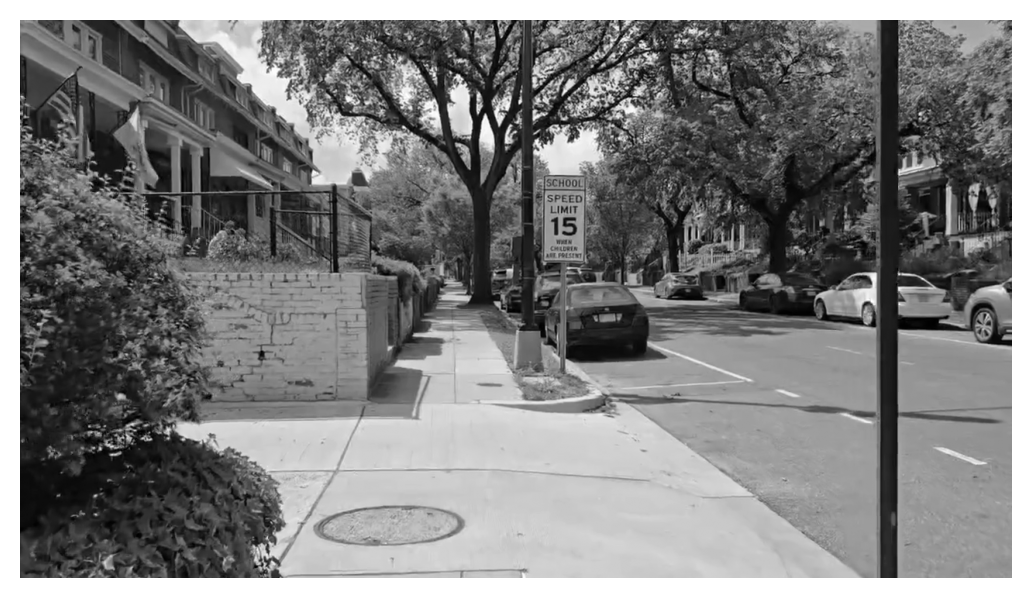

In [ ]:
img0 = cv2.imread(f"{frame_dir}/img_00013.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(f"{frame_dir}/img_00014.png", cv2.IMREAD_GRAYSCALE)
cv2_imshow(img0)

Detected 3000 Harris corners in img0


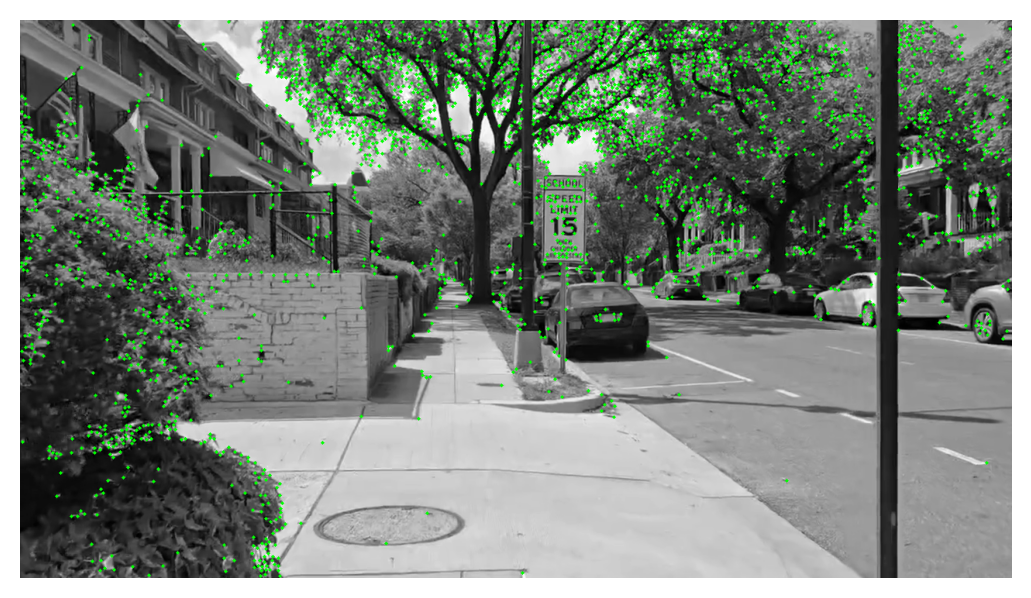

In [ ]:
corners = cv2.goodFeaturesToTrack(img0, maxCorners=3000, qualityLevel=0.01, minDistance=5)
img_debug = cv2.cvtColor(img0.copy(), cv2.COLOR_GRAY2BGR)
if corners is not None:
    for pt in corners:
        x, y = pt[0]
        cv2.circle(img_debug, (int(x), int(y)), 2, (0, 255, 0), -1)
    print(f"Detected {len(corners)} Harris corners in img0")
else:
    print("No corners detected in img0")
cv2_imshow(img_debug)

✅ Using frames 13 and 14 for bootstrap with score 72.54


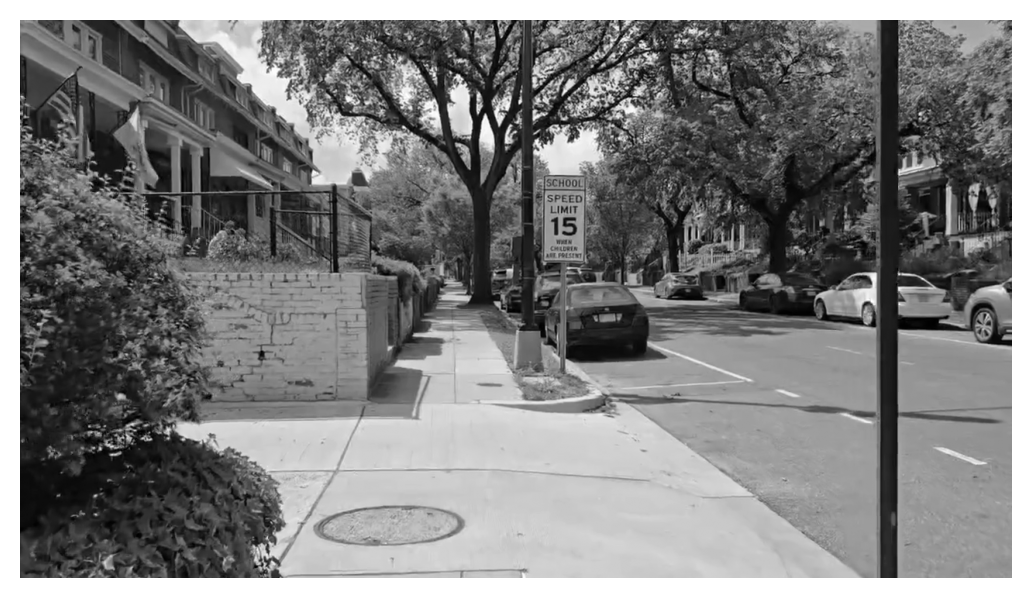

In [ ]:
best_score = -1
best_pair = None
best_kp = None
best_pw = None

for i in range(1, 30):
    img0 = cv2.imread(f"{frame_dir}/img_{i:05d}.png", cv2.IMREAD_GRAYSCALE)
    img1 = cv2.imread(f"{frame_dir}/img_{i+1:05d}.png", cv2.IMREAD_GRAYSCALE)

    kp, pw, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param_bootstrap, display=False)

    if len(kp) < 50 or pw.shape[1] < 30:
        continue

    # Compute spread score (standard deviation of x, y coords)
    arr = np.array(kp)
    spread = np.std(arr, axis=0).sum()

    if spread > best_score:
        best_score = spread
        best_pair = (i, i+1)
        best_kp, best_pw = kp, pw
        selected_R1, selected_T1 = R1, T1

if best_pair is None:
    raise RuntimeError("❌ No suitable bootstrap frame pair found with sufficient and well-distributed keypoints.")

print(f"✅ Using frames {best_pair[0]} and {best_pair[1]} for bootstrap with score {best_score:.2f}")
img0 = cv2.imread(f"{frame_dir}/img_{best_pair[0]:05d}.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(f"{frame_dir}/img_{best_pair[1]:05d}.png", cv2.IMREAD_GRAYSCALE)
cv2_imshow(img0)


[DEBUG] Initial Harris corners: 3000
[DEBUG] KLT-tracked points: 85
[DEBUG] Inliers after Essential Matrix: 85
[DEBUG] Triangulated points with Z > 0: 42 / 67
Number of keypoints after VO_bootstrap: 67
Detected 3000 Harris corners in img1
Triangulated 3D points: 67


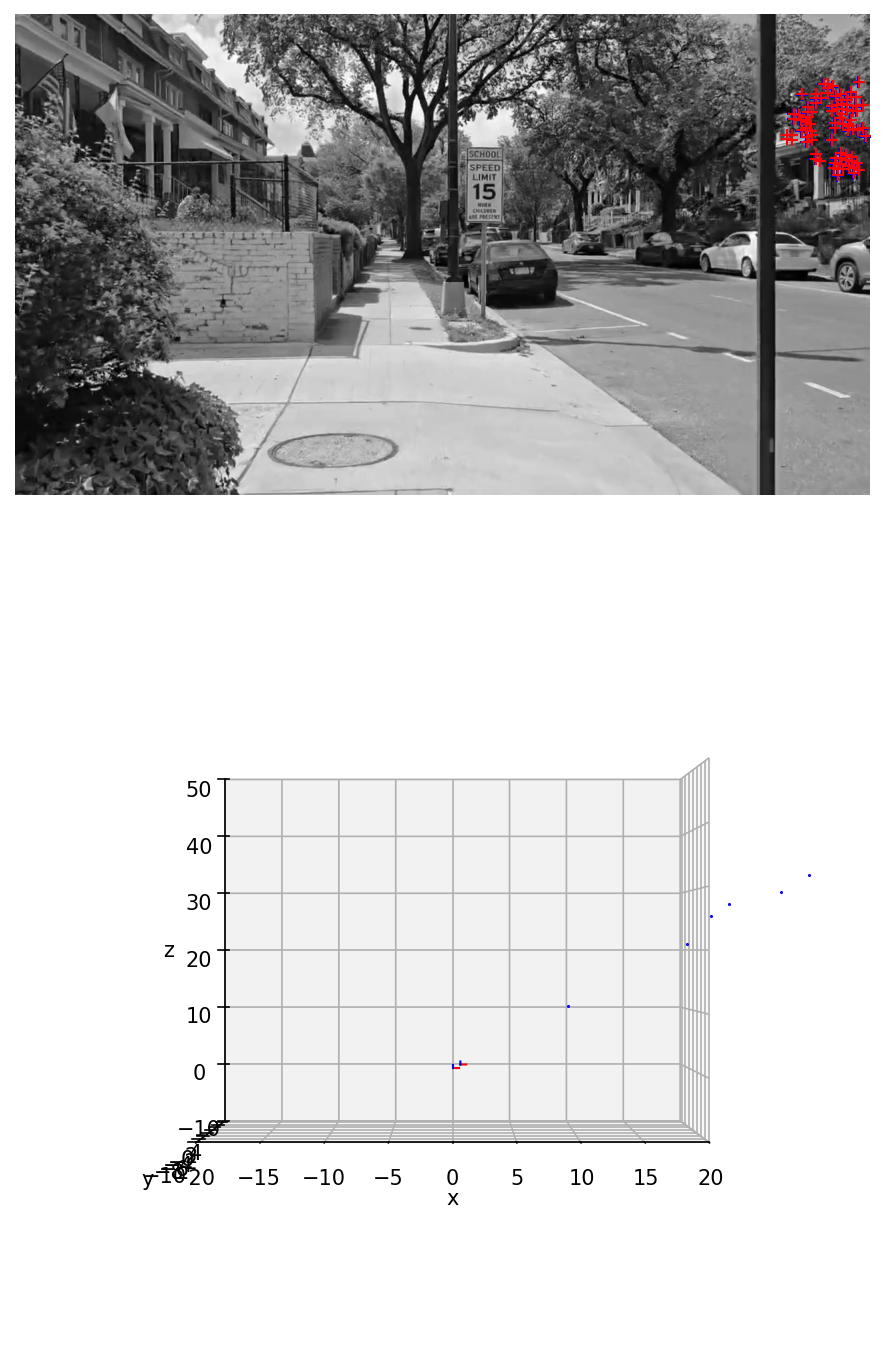

In [ ]:
param_bootstrap = {
    'W_harris_patch': 5,        # larger window for Harris
    'kappa_harris': 0.04,      # more sensitive to edge strength
    'N_keypoint': 3000,        # increase number of keypoints
    'W_nms': 6,                # smaller non-max suppression for density
    'W_KLT': 5,                # slightly larger window for KLT
    'tol_KLT_bidir': 2,        # looser check
    'tol_E': 2,                # looser essential matrix reprojection error
    'tol_E_RANSAC_prob': 0.995, # higher RANSAC confidence
    'tol_TRI_mu': 1e-3,
    'tol_TRI_rep': 2           # more tolerant triangulation reprojection error
}

keypoints0, p_W0, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param_bootstrap, display=True)
print(f"Number of keypoints after VO_bootstrap: {len(keypoints0)}")
corners1 = cv2.goodFeaturesToTrack(img1, maxCorners=3000, qualityLevel=0.01, minDistance=5)
if corners1 is not None:
    print(f"Detected {len(corners1)} Harris corners in img1")
else:
    print("No corners detected in img1")
print(f"Triangulated 3D points: {p_W0.shape[1] if p_W0 is not None else 0}")

In [ ]:
param_mapping = {
    'W_harris_patch': 5,        # slightly larger window
    'kappa_harris': 0.04,      # more sensitive to edges
    'N_keypoint': 3000,        # increase number of keypoints
    'W_nms': 6,                # smaller NMS for denser corners
    'W_KLT': 5,                # slightly larger window for tracking
    'tol_KLT_bidir': 2,        # more lenient bidirectional check
    'tol_TRI_mu': 1e-3,
    'tol_TRI_rep': 2,          # more tolerant reprojection error
    'tol_keypoints_new': 10    # accept keypoints closer to existing ones
}


In [ ]:
img_pre = img0
S_pre = mae6292.state(keypoints0, p_W0, [np.zeros((3,1))])
C_pre = mae6292.candidate([],[],[],[])
# Resume from last partial result if available
# === BATCH CONFIGURATION ===
batch_start = 802  # Change this to resume from a specific frame
batch_size = 200   # Number of frames to process in one run
start_frame = batch_start
N_frames = min(batch_start + batch_size - 1, len([f for f in os.listdir(frame_dir) if f.endswith(".png")]) - 1)
p_W = p_W0


skipped_frames = []
processed_frames = []

import time

for i_frame in range(start_frame, N_frames + 1):
    start_time = time.time()
    if S_pre.p_W.shape[1] < 4:
        print(f"Skipping frame {i_frame:05d} — not enough 3D points.")
        skipped_frames.append(i_frame)
        continue
    print(f"Processing frame {i_frame:05d}...")
    processed_frames.append(i_frame)

    img_path = f"{frame_dir}/img_{i_frame:05d}.png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    try:
        R, T, S, C, fig = mae6292.VO_localization_mapping(
            i_frame, img, img_rgb, img_pre, S_pre, C_pre, K, param_mapping, display_process=True
        )
    except Exception as e:
        print(f" Frame {i_frame:05d} failed: {e}")
        skipped_frames.append(i_frame)
        continue

    img_pre, S_pre, C_pre = img, S, C
    if i_frame >= T_W.shape[1]:
        print(f" Frame {i_frame} exceeds T_W bounds. Expanding T_W...")
        T_W = np.pad(T_W, ((0, 0), (0, 100)), mode='constant')
    T_W[:, i_frame] = (-R.T @ T).flatten()

    p_W_dist = scipy.spatial.distance.cdist(S.p_W.T, p_W.T, 'euclidean')
    index_distinct = np.where(np.min(p_W_dist, axis=1) > 3)[0]
    p_W = np.append(p_W, S.p_W[:, index_distinct], axis=1)

    fig.savefig(f"{output_dir}/frame_{i_frame:05d}.png")
    plt.close(fig)  # Close figure to avoid displaying
    if i_frame % 100 == 0:
        np.save(f"{output_dir}/T_W_partial_{i_frame}.npy", T_W)
        np.save(f"{output_dir}/p_W_partial_{i_frame}.npy", p_W)
        print(f" Progress saved at frame {i_frame} including trajectory and 3D points")
        print(f" Progress saved at frame {i_frame}")
    print(f" Frame {i_frame:05d} completed in {time.time() - start_time:.2f} sec")
    plt.close(fig)  # Close figure to avoid displaying

Processing frame 00802...
 Frame 00802 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00803...
 Frame 00803 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00804...
 Frame 00804 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00805...
 Frame 00805 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoint

In [ ]:
img_pre = img0
S_pre = mae6292.state(keypoints0, p_W0, [np.zeros((3,1))])
C_pre = mae6292.candidate([],[],[],[])
# Resume from last partial result if available
# === BATCH CONFIGURATION ===
batch_start = 801  # Change this to resume from a specific frame
batch_size = 200   # Number of frames to process in one run
start_frame = batch_start
N_frames = min(batch_start + batch_size - 1, len([f for f in os.listdir(frame_dir) if f.endswith(".png")]) - 1)
p_W = p_W0


skipped_frames = []
processed_frames = []

import time

for i_frame in range(start_frame, N_frames + 1):
    start_time = time.time()
    if S_pre.p_W.shape[1] < 4:
        print(f"Skipping frame {i_frame:05d} — not enough 3D points.")
        skipped_frames.append(i_frame)
        continue
    print(f"Processing frame {i_frame:05d}...")
    processed_frames.append(i_frame)

    img_path = f"{frame_dir}/img_{i_frame:05d}.png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    try:
        R, T, S, C, fig = mae6292.VO_localization_mapping(
            i_frame, img, img_rgb, img_pre, S_pre, C_pre, K, param_mapping, display_process=True
        )
    except Exception as e:
        print(f"❌ Frame {i_frame:05d} failed: {e}")
        skipped_frames.append(i_frame)
        R, T, S, C, fig = None, None, None, None, None
        continue

    img_pre, S_pre, C_pre = img, S, C
    if i_frame >= T_W.shape[1]:
        print(f" Frame {i_frame} exceeds T_W bounds. Expanding T_W...")
        T_W = np.pad(T_W, ((0, 0), (0, 100)), mode='constant')
    if R is not None and T is not None:
        if i_frame >= T_W.shape[1]:
            print(f" Frame {i_frame} exceeds T_W bounds. Expanding T_W...")
            T_W = np.pad(T_W, ((0, 0), (0, 200)), mode='constant')
        T_W[:, i_frame] = (-R.T @ T).flatten()

    p_W_dist = scipy.spatial.distance.cdist(S.p_W.T, p_W.T, 'euclidean')
    index_distinct = np.where(np.min(p_W_dist, axis=1) > 3)[0]
    p_W = np.append(p_W, S.p_W[:, index_distinct], axis=1)

    fig.savefig(f"{output_dir}/frame_{i_frame:05d}.png")
    plt.close(fig)  # Close figure to avoid displaying
    if i_frame % 100 == 0:
        np.save(f"{output_dir}/T_W_partial_{i_frame}.npy", T_W)
        np.save(f"{output_dir}/p_W_partial_{i_frame}.npy", p_W)
        print(f"✅ Progress saved at frame {i_frame} including trajectory and 3D points")
        print(f"✅ Progress saved at frame {i_frame}")
    print(f"✅ Frame {i_frame:05d} completed in {time.time() - start_time:.2f} sec")
    plt.close(fig)  # Close figure to avoid displaying


Processing frame 00801...
❌ Frame 00801 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00802...
❌ Frame 00802 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00803...
❌ Frame 00803 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'

Processing frame 00804...
❌ Frame 00804 failed: OpenCV(4.11.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:226: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ip